# Manually Parse GEDI  


In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point

import contextily as ctx
import h5py

In [73]:
import geoviews as gv
import hvplot
import hvplot.pandas

---

In [5]:
# icesat2_path = 'D:/wspace/icesat2/alaska'
# icesat2_path = f'/fs/project/howat.4/yadav.111/icesat2/greenland'
# icesat2_path = 'test_data'
gedi_path = 'D:/icesat2/Gedi'
files = os.listdir(f'{gedi_path}')
hdf_files = [f for f in files if f.endswith('.h5')]#[f for f in files if f.endswith('.h5')]
hdf_files

['GEDI02_A_2019163000018_O02813_T05514_02_001_01.h5']

In [6]:
# for f in hdf_files[5:6]:
f = hdf_files[0]
hdf_path = f'{gedi_path}/{f}'
print(f'{hdf_path} {os.path.exists(hdf_path)}')

D:/icesat2/Gedi/GEDI02_A_2019163000018_O02813_T05514_02_001_01.h5 True


In [7]:
fi = h5py.File(hdf_path, 'r')

In [8]:
fi.keys()

<KeysViewHDF5 ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

In [9]:
beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

In [11]:
# [k for k in list(fi[f'/{beams[0]}/geolocation'].keys()) if k.endswith('_a1')]

In [12]:
# Set/Create Ouput directory
out_path = f'{os.path.splitext(hdf_path)[0]}'
out_path
if not os.path.exists(out_path):
    os.makedirs(out_path)

For each Beam, there seems 3 distinct variables, with corresponding unique lat/lon   
- elev_highestreturn_a1  
- elev_lowestmode_a1  
- elev_lowestreturn_a1  

- elevs_allmodes_a1 but this is 2D, but also with lat/lon

In [14]:
k

'METADATA'

In [33]:
# beam =  beams[1]#beams[1] 'BEAM0000'
for k in list(fi.keys()):
    if k in beams:
        # Get the geolocation data
        geo = fi[f'/{k}/geolocation']
        variables = [key for key in list(geo.keys()) if key.endswith('_a1')]
        #variables = variables[:3] #remove the sensitivity_ax than is a matrix
        # Remove: energy_lowestmode_a1, num_detectedmodes_a1, sensitivity_a1, quality_flag_a1
        for v in variables:
            if 'energy_' in v:
                variables.remove(v)
            if 'num_detectedmodes_' in v:
                variables.remove(v)
            if 'sensitivity_' in v:
                variables.remove(v)            
        var_dict = {}
        for var in variables:
            if geo[var].ndim == 1: #to skip 2D variables
                var_dict[var] = geo[var] #[:] may not be required
        df = pd.DataFrame(var_dict)
        df.to_csv(f'{out_path}/{k}.csv', index=False)

# Analysis
Load the saved dataframes

In [58]:
# out_path
beams

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

In [139]:
df = pd.read_csv(f'{out_path}/{beams[5]}.csv')
df = df[np.logical_and(df.lat_lowestreturn_a1>35, df.lat_lowestreturn_a1<35.2)]
df = df[df.quality_flag_a1==1]

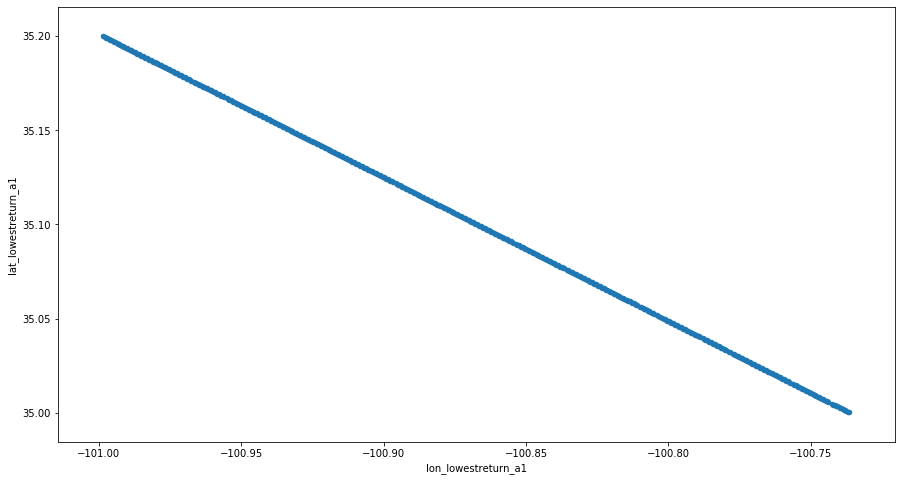

In [140]:
df.plot(kind='scatter', x='lon_lowestreturn_a1', y='lat_lowestreturn_a1')

In [141]:
df['geometry'] = df[['lon_lowestreturn_a1', 'lat_lowestreturn_a1']].apply(lambda x: Point(x), axis=1) #because this takes a long time

In [142]:
gdf = gpd.GeoDataFrame(df[['elev_highestreturn_a1', 'elev_lowestreturn_a1', 'elev_lowestmode_a1','geometry']], geometry='geometry')
gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides

In [143]:
# gdf.to_file(f'{out_path}/{beam[1]}.shp')

In [144]:
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, alpha=0.7, width=500, height=700)

In [145]:
terrain_scatter = df.hvplot(y='lat_lowestreturn_a1', x='elev_lowestreturn_a1', kind='scatter', width=350, height=650, color='brown', s=10, alpha=.9).relabel('terrain')
canopy_scatter = df.hvplot(y='lat_lowestreturn_a1', x='elev_highestreturn_a1', kind='scatter', width=350, height=650, color='green', s=10, alpha=.3, title='GEDI', xlabel='meters').relabel('canopy')
fig1 = (base*gtracks + terrain_scatter*canopy_scatter).cols(2)

In [146]:
fig1

:Layout
   .Overlay.I  :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]
   .Overlay.II :Overlay
      .Scatter.Terrain :Scatter   [elev_lowestreturn_a1]   (lat_lowestreturn_a1)
      .Scatter.Canopy  :Scatter   [elev_highestreturn_a1]   (lat_lowestreturn_a1)

In [156]:
df.iloc[:, :4]

,elev_highestreturn_a1,elev_lowestmode_a1,elev_lowestreturn_a1,lat_highestreturn_a1
659335,943.28850,939.61770,933.84920,35.199836
659336,940.20570,935.89810,929.86743,35.199485
659337,933.70920,929.32670,923.85790,35.199134
659338,938.04144,933.58400,927.44100,35.198785
659339,940.61755,936.53467,930.80370,35.198436
...,...,...,...,...
659899,721.31903,716.89910,711.39290,35.001613
659900,719.48660,715.40375,709.86010,35.001262
659901,718.36920,713.87430,708.29320,35.000912
659902,716.70060,711.86865,706.25006,35.000561


In [157]:
# df.plot(subplots=True, layout = (-1, 3));
df.iloc[:, :4].hvplot(x='lat_highestreturn_a1', width=900)

:NdOverlay   [Variable]
   :Curve   [lat_highestreturn_a1]   (value)

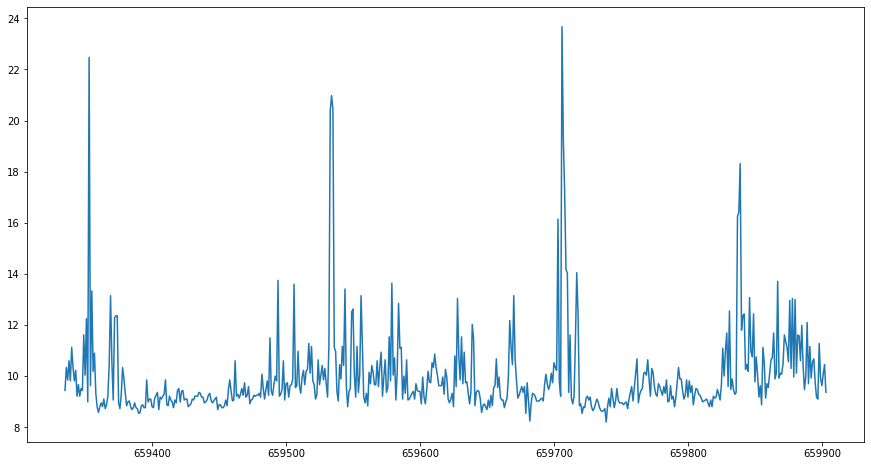

In [154]:
(df.elev_highestreturn_a1 - df.elev_lowestreturn_a1).plot()

In [135]:
# df[df.quality_flag_a1==1][['elev_lowestreturn_a1', 'elev_highestreturn_a1']].hvplot(subplots=False, alpha=.5)

In [136]:
df[df.quality_flag_a1==1][['elev_highestreturn_a1', 'elev_lowestmode_a1', 'elev_lowestreturn_a1']].corr()

,elev_highestreturn_a1,elev_lowestmode_a1,elev_lowestreturn_a1
elev_highestreturn_a1,1.000000,0.999833,0.999787
elev_lowestmode_a1,0.999833,1.000000,0.999956
elev_lowestreturn_a1,0.999787,0.999956,1.000000


In [137]:
# df[df.quality_flag_a1==0][['elev_highestreturn_a1', 'elev_lowestmode_a1', 'elev_lowestreturn_a1']].plot(subplots=False);

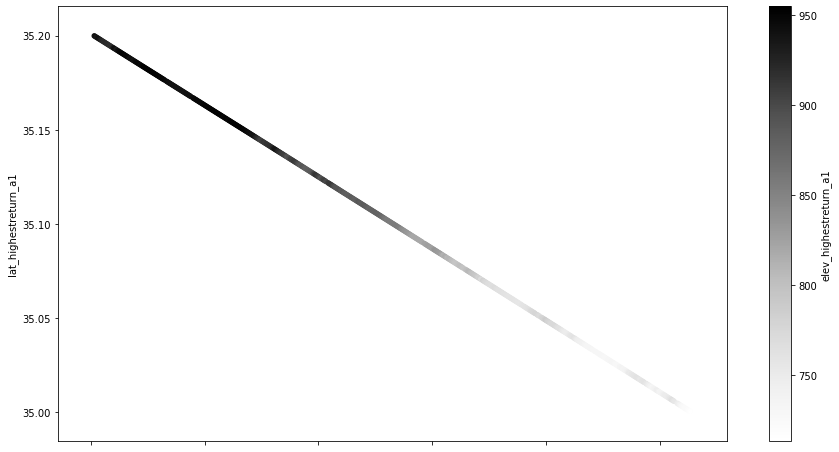

In [158]:
df.plot(kind='scatter', x='lon_highestreturn_a1', y='lat_highestreturn_a1', c='elev_highestreturn_a1');